In [1]:
import sys
sys.path.append('/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/skin-lesion-segmentation-transformer')
from Datasets.create_dataset import norm01, Dataset_wrap, Dataset_wrap_csv
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2

In [2]:
# loading data
datas = Dataset_wrap_csv(k_fold='4', use_old_split=True, img_size=224, 
    dataset_name = 'isic2018', split_ratio=[0.8,0.2], 
    train_aug=True)
train_data, val_data, test_data = datas['train'], datas['test'], datas['test']
data_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=4,
                                            shuffle=False,
                                            num_workers=2,
                                            pin_memory=True,
                                            drop_last=False)
iter_data = iter(data_loader)

isic2018 has 2594 samples, 2076 are used to train, 518 are used to test. 
 5 Folder -- Use 4


In [4]:
from Models.Transformer.SwinUnet import SwinUnet
model = SwinUnet(img_size=256)
model.load_state_dict(torch.load('/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/results/'+
        'V_results/V10/gra_4SwinUnet_four_SwinUnet_20230205_1457/best.pth'))

SwinTransformerSys expand initial----depths:[2, 2, 6, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---


<All keys matched successfully>

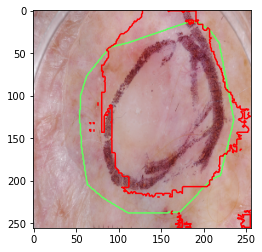

In [31]:
# show image and label, check correspondence
id = 2
model.eval()
# batch = next(iter_data)
img = batch['image'].float()
label = batch['label'].float()
output = model(img)
output = torch.sigmoid(output)
img_np, label_np = img[id].numpy(), label[id].numpy()
output_np = output[id].detach().numpy() > 0.5
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
# de-normalize
img_from_norm = np.zeros_like(img_np)
for i in range(3):
    img_from_norm[i] = img_np[i]*std[i]+mean[i]
img_show, label_show, output_show = np.transpose(img_from_norm, (1,2,0)), np.transpose(label_np, (1,2,0)), np.transpose(output_np, (1,2,0))
img_show, label_show, output_show = np.clip(img_show*255, 0, 255).astype(np.uint8), np.clip(label_show*255, 0, 255).astype(np.uint8), np.clip(output_show*255, 0, 255).astype(np.uint8)
# print(label_show.shape)
label_edges, _ = cv2.findContours(label_show, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
output_edges, _ = cv2.findContours(output_show, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
x, y = label_edges[0][:,0,0], label_edges[0][:,0,1]
x_o, y_o = output_edges[0][:,0,0], output_edges[0][:,0,1]
# # print(img_show)
# plt.subplot(3,1,1)
plt.imshow(img_show)
plt.plot(x,y,c='#60FF5F')
for edge in output_edges:
    plt.plot(edge[:,0,0],edge[:,0,1],c='#FF0004')

# plt.imshow(255-label_edges, cmap='gray', alpha=0.6)
# plt.subplot(3,1,2)
# plt.imshow(label_show, cmap='gray')
# plt.subplot(3,1,3)
# plt.imshow(output_show, cmap='gray')

In [24]:
print(output_edges[4].shape)


(33, 1, 2)


In [ ]:
# plt many figures
batch = next(iter_data)
fig = plt.figure(figsize=(15,15)) # 50
# fig = plt.figure()
num=16 # number of images to show
img = batch['image'].float()
label = batch['label'].float()
path = batch['image_path']
output = model(img)
output = torch.sigmoid(output)
img_np, label_np = img.numpy(), label.numpy()
output_np = output.detach().numpy() > 0.5
# output_np = np.zeros_like(label_np)
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
# de-normalize
img_from_norm = np.zeros_like(img_np)
# print(output_np.shape)
for i in range(3):
    img_from_norm[:,i,...] = img_np[:,i,...]*std[i]+mean[i]
# img_show, label_show, output_show = np.transpose(img_from_norm, (1,2,0)), np.transpose(label_np, (1,2,0)), np.transpose(output_np, (1,2,0))
for j in range(num):
    fig.add_subplot(num/3+1, 3, j+1)
    img_show, label_show, output_show = np.transpose(img_from_norm[j], (1,2,0)), np.transpose(label_np[j], (1,2,0)), np.transpose(output_np[j], (1,2,0))
    plt.imshow(np.hstack((img_show,label_show.repeat(3,axis=2),output_show.repeat(3,axis=2))))
    plt.title(path[j][40:-4])
    plt.axis('off')


***

**plot images for many models for Sup Visualization**

In [3]:
# loading data
from Datasets.create_dataset import Dataset_wrap_csv
dataset_name='isic2018'
datas = Dataset_wrap_csv(k_fold='4', use_old_split=True, img_size=224, 
    dataset_name = dataset_name, split_ratio=[0.8,0.2], 
    train_aug=True)
train_data, val_data, test_data = datas['train'], datas['test'], datas['test']
data_loader = torch.utils.data.DataLoader(test_data,
                                            batch_size=40,
                                            shuffle=False,
                                            num_workers=2,
                                            pin_memory=True,
                                            drop_last=False)
iter_data = iter(data_loader)

isic2018 has 2594 samples, 2076 are used to train, 518 are used to test. 
 5 Folder -- Use 4


In [3]:
# load model
import yaml
from tqdm import tqdm
from Models.Transformer.UFAT import FATNet
from Models.Transformer.UFAT_for_adapt_KT import FATNet_KT_adapt
from monai.networks.nets import SwinUNETR
from Models.Hybrid_models.TransFuseFolder.TransFuse import TransFuse_S
from Models.Hybrid_models.UTNetFolder.UTNet import UTNet
from Models.Transformer.SwinUnet import SwinUnet
sys.path.append('/ubc/ece/home/ra/grads/siyi/Research/courses_firstyear/CPSC533R/BA-Transformer-main')
from BAT_simple.BAT_main import BAT
model_name_list = ['BASE', 'BAT', 'SwinUNTER', 'TransFuse', 'UTNet', 'SwinUnet', 'MDViT']                  
model_path_dic = yaml.load(open('model_path.yml'), Loader=yaml.FullLoader)
# print(model_path_dic[dataset_name])

In [169]:
# generate predicted maps
batch = next(iter_data)
img = batch['image'].float().cuda()
label = batch['label'].float().cuda()
domain_label = batch['set_id']
domain_label_oh = torch.nn.functional.one_hot(domain_label, 4).float().cuda()
img_np, label_np = img.cpu().numpy(), label.cpu().numpy()
path = batch['image_path']
ST_list = []
JT_list = []
for model_name in tqdm(model_name_list):
    if model_name == 'BASE':
        model = FATNet(drop_rate=0.1, drop_path_rate=0.1, conv_norm=torch.nn.BatchNorm2d)
    elif model_name == 'BAT':
        model = BAT(1, 34, 1, 6)
    elif model_name == 'SwinUNTER': 
        model = SwinUNETR(img_size=(256,256), in_channels=3, out_channels=1, feature_size=48, use_checkpoint=False, spatial_dims=2)
    elif model_name == 'TransFuse':
        model = TransFuse_S(pretrained=False)
    elif model_name == 'UTNet':
        model = UTNet(in_chan=3,base_chan=32,num_classes=1,reduce_size=8,block_list='1234',num_blocks=[1,1,1,1],
                        num_heads=[4,4,4,4], projection='interp', attn_drop=0.1, proj_drop=0.1, rel_pos=True, aux_loss=False, maxpool=True)
    elif model_name == 'SwinUnet':
        model = SwinUnet(img_size=256)
    elif model_name == 'MDViT':
        model = FATNet_KT_adapt(img_size=256, drop_rate=0.1, drop_path_rate=0.1,
                        conv_norm=torch.nn.BatchNorm2d, adapt_method='Sup', num_domains=4, do_detach=False, decoder_name='MLPFM')
    
    # ST
    for setting in [dataset_name, 'JT']:
        model.load_state_dict(torch.load('/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/results/'+
        'V_results/{}/best.pth'.format(model_path_dic[setting][model_name])))
        model.cuda()
        model.eval()
        with torch.no_grad():
            if model_name == 'MDViT':
                output = model(img, domain_label_oh)
                output = output[0]
            elif model_name == 'TransFuse':
                _, _, output = model(img) 
            elif model_name == 'BAT':
                output, _ = model(img)
            else:
                output = model(img)
            output = torch.sigmoid(output)
            output_np = output.detach().cpu().numpy() > 0.5
            if setting == dataset_name:
                ST_list.append(output_np)
            elif setting == 'JT':
                JT_list.append(output_np)

# for i in range(len(ST_list)):
#     print(ST_list[i].shape)
# for i in range(len(JT_list)):
#     print(JT_list[i].shape)

 14%|█▍        | 1/7 [00:06<00:41,  6.89s/it]

resnet34 pretrain False
pretrained resnet, 34


/ubc/ece/home/ra/grads/siyi/anaconda3/envs/skinlesion/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
 71%|███████▏  | 5/7 [00:32<00:12,  6.14s/it]

SwinTransformerSys expand initial----depths:[2, 2, 6, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---


100%|██████████| 7/7 [00:42<00:00,  6.08s/it]


In [ ]:
# plot figure
fig = plt.figure(figsize=(200,200)) # 50
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
# de-normalize
img_from_norm = np.zeros_like(img_np)
num = 80
# print(output_np.shape)
for i in range(3):
    img_from_norm[:,i,...] = img_np[:,i,...]*std[i]+mean[i]
# img_show, label_show, output_show = np.transpose(img_from_norm, (1,2,0)), np.transpose(label_np, (1,2,0)), np.transpose(output_np, (1,2,0))
for j in range(num//2):
    fig.add_subplot(num+1, 1, 2*j+1)
    img_show, label_show = np.transpose(img_from_norm[j], (1,2,0)), np.transpose(label_np[j], (1,2,0))
    ST_show_map = np.hstack((img_show,label_show.repeat(3,axis=2)))
    for output_np in ST_list:
        output_show = np.transpose(output_np[j], (1,2,0))
        ST_show_map = np.hstack((ST_show_map, output_show.repeat(3,axis=2)))
    plt.imshow(ST_show_map)
    plt.title('ID: '+str(j)+'  '+path[j][40:-4])
    plt.axis('off')

    fig.add_subplot(num+1, 1, 2*j+2)
    JT_show_map = np.hstack((img_show,label_show.repeat(3,axis=2)))
    for output_np in JT_list:
        output_show = np.transpose(output_np[j], (1,2,0))
        JT_show_map = np.hstack((JT_show_map, output_show.repeat(3,axis=2)))
    plt.imshow(JT_show_map)
    plt.axis('off')

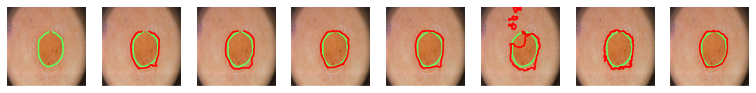

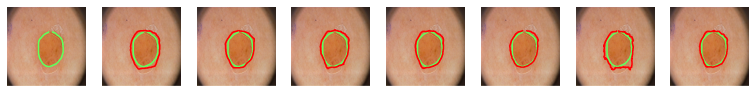

In [181]:
# # show contours
def plot_contours(edges, color):
    for edge in edges:
        plt.plot(edge[:,0,0], edge[:,0,1], c=color)


id = 32


fig = plt.figure(figsize=(15,15)) # 50
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
# de-normalize
img_from_norm = np.zeros_like(img_np)
num = len(model_name_list)
# print(output_np.shape)
for i in range(3):
    img_from_norm[:,i,...] = img_np[:,i,...]*std[i]+mean[i]
# img_show, label_show, output_show = np.transpose(img_from_norm, (1,2,0)), np.transpose(label_np, (1,2,0)), np.transpose(output_np, (1,2,0))
img_show, label_show = np.transpose(img_from_norm[id], (1,2,0)), np.transpose(label_np[id], (1,2,0))
img_show, label_show = np.clip(img_show*255, 0, 255).astype(np.uint8), np.clip(label_show*255, 0, 255).astype(np.uint8)
label_edges, _ = cv2.findContours(label_show, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
fig.add_subplot(1,num+2,1)
plt.imshow(img_show)
plot_contours(label_edges, color='#60FF5F')
plt.axis('off')


for j in range(num):
    fig.add_subplot(1, num+2, j+2)
    output_show = np.transpose(ST_list[j][id], (1,2,0))
    output_show = np.clip(output_show*255, 0, 255).astype(np.uint8)
    output_edges, _ = cv2.findContours(output_show, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    plt.imshow(img_show)
    plot_contours(label_edges, color='#60FF5F')
    plot_contours(output_edges, color='#FF0004')
    plt.axis('off')

fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,num+2,1)
plt.imshow(img_show)
plot_contours(label_edges, color='#60FF5F')
plt.axis('off')

for j in range(num):
    fig.add_subplot(1, num+2, j+2)
    output_show = np.transpose(JT_list[j][id], (1,2,0))
    output_show = np.clip(output_show*255, 0, 255).astype(np.uint8)
    output_edges, _ = cv2.findContours(output_show, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    plt.imshow(img_show)
    plot_contours(label_edges, color='#60FF5F')
    plot_contours(output_edges, color='#FF0004')
    plt.axis('off')

In [ ]:
# generate a concat figure
# generate ground-truth

id=32


def plot_contours(edges, color):
    for edge in edges:
        plt.plot(edge[:,0,0], edge[:,0,1], c=color, linewidth=2.0)


fig = plt.figure(figsize=(5,5), dpi=100) # 50
img_show, label_show = np.transpose(img_from_norm[id], (1,2,0)), np.transpose(label_np[id], (1,2,0))
img_show, label_show = np.clip(img_show*255, 0, 255).astype(np.uint8), np.clip(label_show*255, 0, 255).astype(np.uint8)
label_edges, _ = cv2.findContours(label_show, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
save_path = '/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/figures/sup/Seg/{}/{}_ground.jpg'.format(dataset_name,id)

plt.imshow(img_show)
plot_contours(label_edges, color='#60FF5F')
plt.axis('off')
plt.savefig(save_path, bbox_inches='tight', pad_inches=0)


# store image for each model
for j in range(num):
    fig = plt.figure(figsize=(5,5), dpi=100)
    output_show = np.transpose(ST_list[j][id], (1,2,0))
    output_show = np.clip(output_show*255, 0, 255).astype(np.uint8)
    output_edges, _ = cv2.findContours(output_show, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    plt.imshow(img_show)
    plot_contours(label_edges, color='#60FF5F')
    plot_contours(output_edges, color='#FF0004')
    plt.axis('off')
    save_path = '/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/figures/sup/Seg/{}/{}_ST_{}.jpg'.format(dataset_name,id,model_name_list[j])
    plt.savefig(save_path,bbox_inches='tight', pad_inches=0)  

for j in range(num):
    fig = plt.figure(figsize=(5,5), dpi=100)
    output_show = np.transpose(JT_list[j][id], (1,2,0))
    output_show = np.clip(output_show*255, 0, 255).astype(np.uint8)
    output_edges, _ = cv2.findContours(output_show, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    plt.imshow(img_show)
    plot_contours(label_edges, color='#60FF5F')
    plot_contours(output_edges, color='#FF0004')
    plt.axis('off')
    save_path = '/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/figures/sup/Seg/{}/{}_JT_{}.jpg'.format(dataset_name,id,model_name_list[j])
    plt.savefig(save_path,bbox_inches='tight', pad_inches=0)  


for setting in ['ST','JT']:
    for j in range(num):
        fig = plt.figure(figsize=(5,5), dpi=100)
        if setting == 'ST':
            output_show = np.transpose(ST_list[j][id], (1,2,0))
        else:
            output_show = np.transpose(JT_list[j][id], (1,2,0))
        output_show = np.clip(output_show*255, 0, 255).astype(np.uint8)
        output_edges, _ = cv2.findContours(output_show, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        plt.imshow(img_show)
        plot_contours(label_edges, color='#60FF5F')
        plot_contours(output_edges, color='#FF0004')
        plt.axis('off')
        save_path = '/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/figures/sup/Seg/{}/{}_{}_{}.jpg'.format(dataset_name,id,setting,model_name_list[j])
        plt.savefig(save_path,bbox_inches='tight', pad_inches=0)  


    # concat images across models and get a big image
    fig = plt.figure(figsize=(5*(num+1),5), dpi=100)
    big_img = plt.imread('/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/figures/sup/Seg/{}/{}_ground.jpg'.format(dataset_name,id))
    for model_name in model_name_list:
        img = plt.imread('/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/figures/sup/Seg/{}/{}_{}_{}.jpg'.format(dataset_name,id,setting,model_name))
        big_img = np.hstack((big_img, img))
    plt.imshow(big_img)
    plt.axis('off')
    save_path = '/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/figures/sup/Seg/{}/a_{}_{}.jpg'.format(dataset_name,id,setting)
    plt.savefig(save_path,bbox_inches='tight', pad_inches=0)  

***
Search for the best visualization
best case = MDViT has the best dice and MDViT's dice - the second best dice is the largest
* According to the dice csv, get the best case, a table having csv index, img ID, superior=MDViT-the second best dice
* show a histogram
* Show some visualizations  best, fair, worse

In [792]:
dataset_name = 'PH2'
df = pd.read_csv('/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/results/V_results/{}.csv'.format(dataset_name),
        dtype={'ID': str})

In [793]:
df = df.drop(columns=['MDViT_ST'])
# df

In [794]:
# store our model beats others
tmp_df = df
best_model = 'MDViT_JT'
tmp_df['max_label'] = (df.loc[:,'BASE_ST':'MDViT_JT']).idxmax(axis=1)
tmp_df['max_value'] = (df.loc[:,'BASE_ST':'MDViT_JT']).max(axis=1)

# .idxmax(axis=1)
our_df = tmp_df.loc[tmp_df['max_label']==best_model].copy()
# our_df

In [795]:
tmp_df = our_df.drop(columns=[best_model])
# tmp_df
# tmp_df.columns[3:-2]
our_df['second_label'] = (tmp_df[tmp_df.columns[3:-2]]).idxmax(axis=1)
our_df['second_value'] = (tmp_df[tmp_df.columns[3:-2]]).max(axis=1)

In [796]:
our_df['super'] = our_df['max_value']-our_df['second_value']

In [769]:
our_df = our_df.sort_values(by='super',ascending=False)

In [797]:
our_df

index      ID dataset   BASE_ST   BASE_JT    BAT_ST    BAT_JT  \
3       3  IMD090     PH2  0.925027  0.964037  0.939132  0.892541   
15     15  IMD197     PH2  0.960430  0.951278  0.952986  0.942169   
22     22  IMD147     PH2  0.961062  0.946249  0.956550  0.903566   
23     23  IMD038     PH2  0.902494  0.933785  0.912930  0.912659   
31     31  IMD418     PH2  0.951883  0.754789  0.947183  0.774066   
32     32  IMD010     PH2  0.883944  0.849880  0.861533  0.896280   
36     36  IMD419     PH2  0.984918  0.988831  0.977310  0.987207   
37     37  IMD035     PH2  0.859427  0.685940  0.840747  0.792352   
39     39  IMD064     PH2  0.971142  0.986154  0.980895  0.977988   

    SwinUNTER_ST  SwinUNTER_JT  TransFuse_ST  ...  UTNet_ST  UTNet_JT  \
3       0.952957      0.942756      0.960866  ...  0.930554  0.950621   
15      0.884781      0.945346      0.969169  ...  0.956417  0.944351   
22      0.957036      0.960432      0.961401  ...  0.962085  0.937379   
23      0.911740      0.942822      0.934130  ...  0.915274  0.921512   
31      0.955496      0.940446      0.958723  ...  0.938642  0.902973   
32      0.905747      0.894246      0.877347  ...  0.725691  0.914038   
36      0.982177      0.985541      0.989063  ...  0.967562  0.990505   
37      0.806303      0.796028      0.865333  ...  0.638295  0.796487   
39      0.977136      0.973851      0.980244  ...  0.746407  0.985702   

    SwinUnet_ST  SwinUnet_JT  MDViT_JT  max_label max_value  second_label  \
3      0.933057     0.939749  0.974313   MDViT_JT  0.974313       BASE_JT   
15     0.958676     0.950185  0.969501   MDViT_JT  0.969501  TransFuse_ST   
22     0.954378     0.946864  0.966138   MDViT_JT  0.966138      UTNet_ST   
23     0.918284     0.951732  0.952090   MDViT_JT  0.952090   SwinUnet_JT   
31     0.958168     0.958786  0.960103   MDViT_JT  0.960103   SwinUnet_JT   
32     0.855265     0.855015  0.916049   MDViT_JT  0.916049      UTNet_JT   
36     0.982883     0.987110  0.992576   MDViT_JT  0.992576      UTNet_JT   
37     0.803445     0.779429  0.875279   MDViT_JT  0.875279  TransFuse_ST   
39     0.977024     0.975577  0.990574   MDViT_JT  0.990574       BASE_JT   

   second_value     super  
3      0.964037  0.010277  
15     0.969169  0.000332  
22     0.962085  0.004053  
23     0.951732  0.000358  
31     0.958786  0.001317  
32     0.914038  0.002010  
36     0.990505  0.002070  
37     0.865333  0.009947  
39     0.986154  0.004420  

[9 rows x 21 columns]

In [798]:
# plot figures
from Datasets.create_dataset import Dataset_wrap_csv
datas = Dataset_wrap_csv(k_fold='4', use_old_split=True, img_size=256, 
    dataset_name = dataset_name, split_ratio=[0.8,0.2], 
    train_aug=True)
train_data, val_data, test_data = datas['train'], datas['test'], datas['test']
# load model
import yaml
from tqdm import tqdm
from Models.Transformer.UFAT import FATNet
from Models.Transformer.UFAT_for_adapt_KT import FATNet_KT_adapt
from monai.networks.nets import SwinUNETR
from Models.Hybrid_models.TransFuseFolder.TransFuse import TransFuse_S
from Models.Hybrid_models.UTNetFolder.UTNet import UTNet
from Models.Transformer.SwinUnet import SwinUnet
sys.path.append('/ubc/ece/home/ra/grads/siyi/Research/courses_firstyear/CPSC533R/BA-Transformer-main')
from BAT_simple.BAT_main import BAT
model_name_list = ['BASE', 'SwinUnet', 'UTNet', 'BAT', 'TransFuse', 'SwinUNTER','MDViT']
# model_name_list = ['BASE', 'BAT', 'SwinUNTER', 'TransFuse', 'UTNet', 'SwinUnet', 'MDViT']                  
model_path_dic = yaml.load(open('model_path.yml'), Loader=yaml.FullLoader)

PH2 has 200 samples, 160 are used to train, 40 are used to test. 
 5 Folder -- Use 4


In [815]:
index = 37
sample = test_data[index]

img = sample['image'].unsqueeze(0).float().cuda()
label = sample['label'].unsqueeze(0).float().cuda()
domain_label = torch.tensor([sample['set_id']])
domain_label_oh = torch.nn.functional.one_hot(domain_label, 4).float().cuda()
img_np, label_np = img.cpu().numpy(), label.cpu().numpy()
path = sample['image_path']
ST_list = []
JT_list = []
for model_name in tqdm(model_name_list):
    if model_name == 'BASE':
        model = FATNet(drop_rate=0.1, drop_path_rate=0.1, conv_norm=torch.nn.BatchNorm2d)
    elif model_name == 'BAT':
        model = BAT(1, 34, 1, 6)
    elif model_name == 'SwinUNTER': 
        model = SwinUNETR(img_size=(256,256), in_channels=3, out_channels=1, feature_size=48, use_checkpoint=False, spatial_dims=2)
    elif model_name == 'TransFuse':
        model = TransFuse_S(pretrained=False)
    elif model_name == 'UTNet':
        model = UTNet(in_chan=3,base_chan=32,num_classes=1,reduce_size=8,block_list='1234',num_blocks=[1,1,1,1],
                        num_heads=[4,4,4,4], projection='interp', attn_drop=0.1, proj_drop=0.1, rel_pos=True, aux_loss=False, maxpool=True)
    elif model_name == 'SwinUnet':
        model = SwinUnet(img_size=256)
    elif model_name == 'MDViT':
        model = FATNet_KT_adapt(img_size=256, drop_rate=0.1, drop_path_rate=0.1,
                        conv_norm=torch.nn.BatchNorm2d, adapt_method='Sup', num_domains=4, do_detach=False, decoder_name='MLPFM')
    
    # ST
    for setting in [dataset_name, 'JT']:
        model.load_state_dict(torch.load('/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/results/'+
        'V_results/{}/best.pth'.format(model_path_dic[setting][model_name])))
        model.cuda()
        model.eval()
        with torch.no_grad():
            if model_name == 'MDViT':
                output = model(img, domain_label_oh)
                output = output[0]
            elif model_name == 'TransFuse':
                _, _, output = model(img) 
            elif model_name == 'BAT':
                output, _ = model(img)
            else:
                output = model(img)
            output = torch.sigmoid(output)
            output_np = output.detach().cpu().numpy() > 0.5
            if setting == dataset_name:
                ST_list.append(output_np)
            elif setting == 'JT':
                JT_list.append(output_np)

 14%|█▍        | 1/7 [00:00<00:03,  1.67it/s]

SwinTransformerSys expand initial----depths:[2, 2, 6, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---


 43%|████▎     | 3/7 [00:01<00:01,  2.30it/s]

resnet34 pretrain False
pretrained resnet, 34


/ubc/ece/home/ra/grads/siyi/anaconda3/envs/skinlesion/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


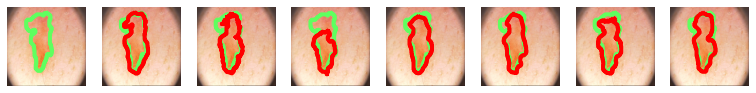

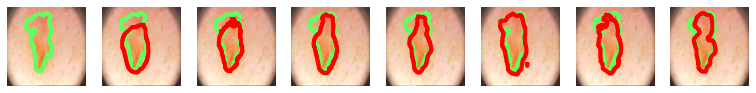

In [816]:
id = 0 

def plot_contours(edges, color):
    for edge in edges:
        plt.plot(edge[:,0,0], edge[:,0,1], c=color, linewidth=4.0)

fig = plt.figure(figsize=(15,15)) # 50
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
# de-normalize
img_from_norm = np.zeros_like(img_np)
num = len(model_name_list)
# print(output_np.shape)
for i in range(3):
    img_from_norm[:,i,...] = img_np[:,i,...]*std[i]+mean[i]
# img_show, label_show, output_show = np.transpose(img_from_norm, (1,2,0)), np.transpose(label_np, (1,2,0)), np.transpose(output_np, (1,2,0))
img_show, label_show = np.transpose(img_from_norm[id], (1,2,0)), np.transpose(label_np[id], (1,2,0))
img_show, label_show = np.clip(img_show*255, 0, 255).astype(np.uint8), np.clip(label_show*255, 0, 255).astype(np.uint8)
label_edges, _ = cv2.findContours(label_show, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
fig.add_subplot(1,num+2,1)
plt.imshow(img_show)
plot_contours(label_edges, color='#60FF5F')
plt.axis('off')


for j in range(num):
    fig.add_subplot(1, num+2, j+2)
    output_show = np.transpose(ST_list[j][id], (1,2,0))
    output_show = np.clip(output_show*255, 0, 255).astype(np.uint8)
    output_edges, _ = cv2.findContours(output_show, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    plt.imshow(img_show)
    plot_contours(label_edges, color='#60FF5F')
    # plot_contours(output_edges, color='#FF0004')
    plot_contours(output_edges, color='#FF0000')
    plt.axis('off')

fig = plt.figure(figsize=(15,15))
fig.add_subplot(1,num+2,1)
plt.imshow(img_show)
plot_contours(label_edges, color='#60FF5F')
plt.axis('off')

for j in range(num):
    fig.add_subplot(1, num+2, j+2)
    output_show = np.transpose(JT_list[j][id], (1,2,0))
    output_show = np.clip(output_show*255, 0, 255).astype(np.uint8)
    output_edges, _ = cv2.findContours(output_show, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    plt.imshow(img_show)
    plot_contours(label_edges, color='#60FF5F')
    plot_contours(output_edges, color='#FF0000')
    plt.axis('off')

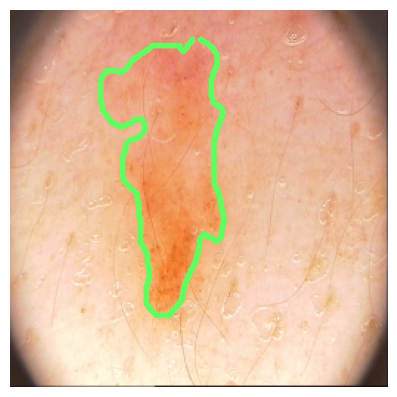

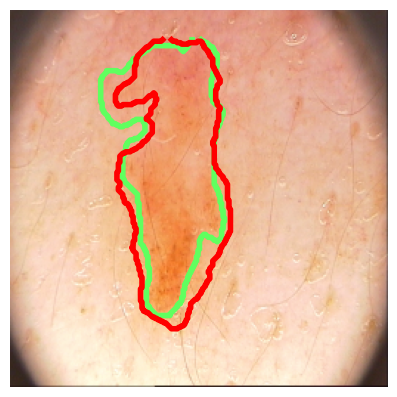

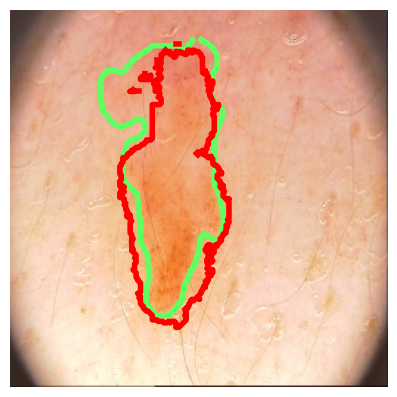

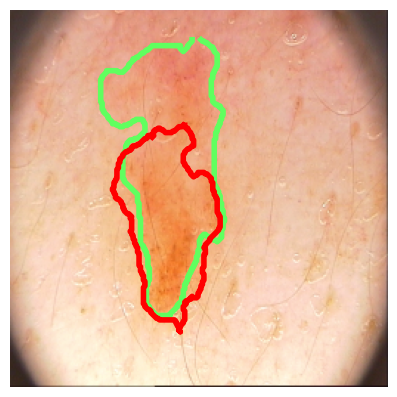

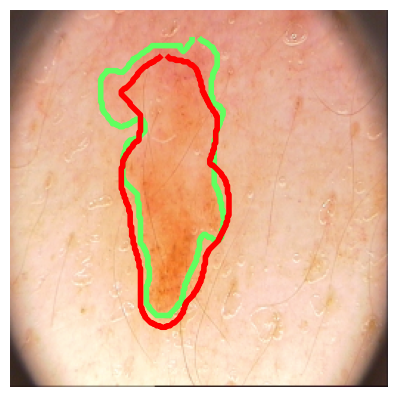

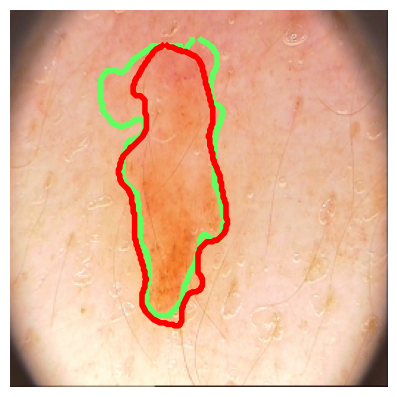

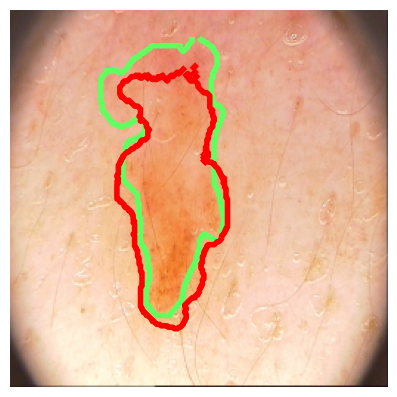

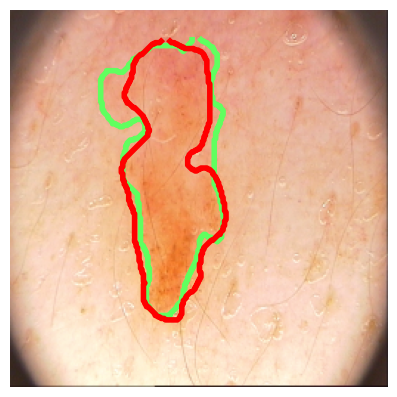

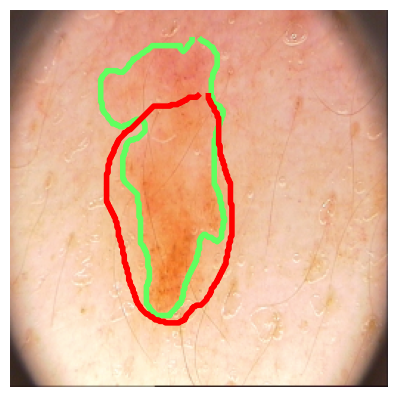

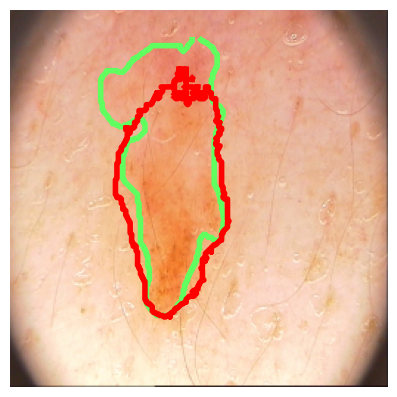

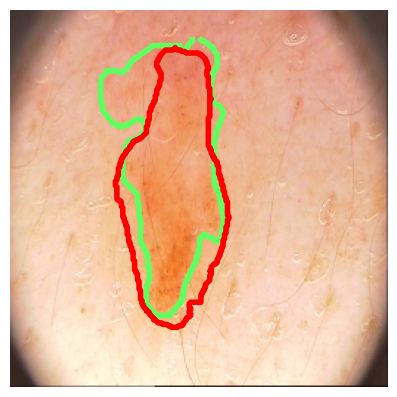

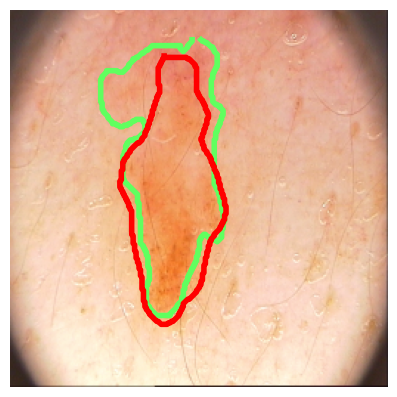

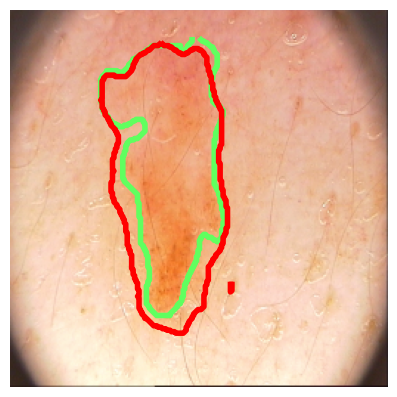

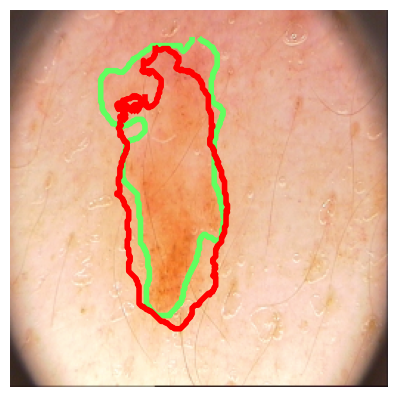

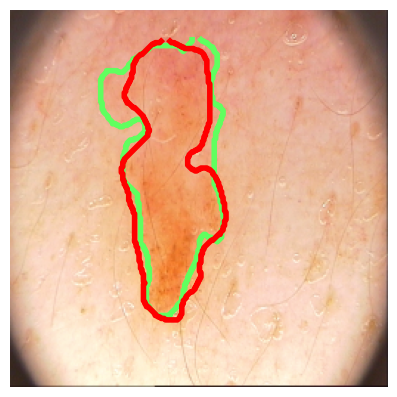

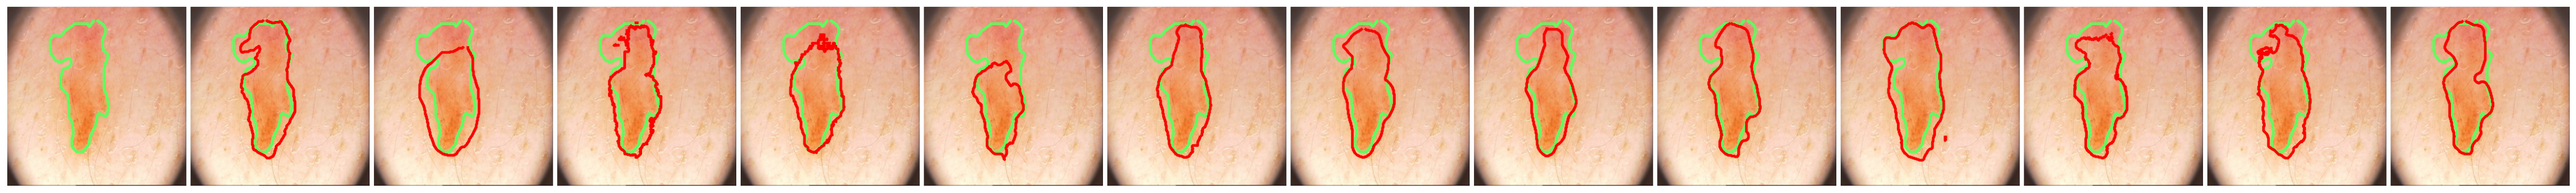

In [817]:
# # store tight figure


store_folder = '/ubc/ece/home/ra/grads/siyi/Research/skin_lesion_segmentation/figures/sup/Seg/dice_rank'

fig = plt.figure(figsize=(5,5), dpi=100) # 50
img_show, label_show = np.transpose(img_from_norm[id], (1,2,0)), np.transpose(label_np[id], (1,2,0))
img_show, label_show = np.clip(img_show*255, 0, 255).astype(np.uint8), np.clip(label_show*255, 0, 255).astype(np.uint8)
label_edges, _ = cv2.findContours(label_show, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
save_path = store_folder+'/{}/{}_ground.jpg'.format(dataset_name,index)
padding = 0.05

plt.imshow(img_show)
plot_contours(label_edges, color='#60FF5F')
plt.axis('off')
plt.savefig(save_path, bbox_inches='tight', pad_inches=padding)


for setting in ['ST','JT']:
    for j in range(num):
        fig = plt.figure(figsize=(5,5), dpi=100)
        if setting == 'ST':
            output_show = np.transpose(ST_list[j][id], (1,2,0))
        else:
            output_show = np.transpose(JT_list[j][id], (1,2,0))
        output_show = np.clip(output_show*255, 0, 255).astype(np.uint8)
        output_edges, _ = cv2.findContours(output_show, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        plt.imshow(img_show)
        plot_contours(label_edges, color='#60FF5F')
        plot_contours(output_edges, color='#FF0000')
        plt.axis('off')
        save_path = store_folder+'/{}/{}_{}_{}.jpg'.format(dataset_name,index,setting,model_name_list[j])
        plt.savefig(save_path,bbox_inches='tight', pad_inches=padding)  


    # # concat images across models and get a big image
    # fig = plt.figure(figsize=(5*(num+1),5), dpi=100)
    # big_img = plt.imread(store_folder+'/{}/{}_ground.jpg'.format(dataset_name,index))
    # for model_name in model_name_list:
    #     img = plt.imread(store_folder+'/{}/{}_{}_{}.jpg'.format(dataset_name,index,setting,model_name))
    #     big_img = np.hstack((big_img, img))
    # plt.imshow(big_img)
    # plt.axis('off')
    # save_path = store_folder+'/{}/a_{}_{}.jpg'.format(dataset_name,index,setting)
    # plt.savefig(save_path,bbox_inches='tight', pad_inches=0)  

fig = plt.figure(figsize=(5*(num*2+1),5), dpi=100)
big_img = plt.imread(store_folder+'/{}/{}_ground.jpg'.format(dataset_name,index))
for model_name in model_name_list:
    for setting in ['ST', 'JT']:
        if model_name == 'MDViT' and setting=='ST': continue
        img = plt.imread(store_folder+'/{}/{}_{}_{}.jpg'.format(dataset_name,index,setting,model_name))
        big_img = np.hstack((big_img, img))
plt.imshow(big_img)
plt.axis('off')
save_path = store_folder+'/{}/b_{}.jpg'.format(dataset_name,index)
plt.savefig(save_path,bbox_inches='tight', pad_inches=0)  

In [818]:
# concat images across models and get a big image
# dataset_name = 'PH2'
# index = 37
fig = plt.figure(figsize=(5*(num*2+1),5), dpi=100)
big_img = plt.imread(store_folder+'/{}/{}_ground.jpg'.format(dataset_name,index))
for model_name in model_name_list:
    for setting in ['ST', 'JT']:
        if model_name == 'MDViT' and setting=='ST':
        img = plt.imread(store_folder+'/{}/{}_{}_{}.jpg'.format(dataset_name,index,setting,model_name))
        big_img = np.hstack((big_img, img))
plt.imshow(big_img)
plt.axis('off')
save_path = store_folder+'/{}/b_{}.jpg'.format(dataset_name,index)
plt.savefig(save_path,bbox_inches='tight', pad_inches=0)  

IndentationError: expected an indented block (1923108157.py, line 9)